In [36]:
import numpy as np

from datastructures import *
from training import *
from models import *

In [37]:
# === Inverse task: curvature -> markers =======================================

data_dir = "training_data"
graphs = load_dir_to_graphs(data_dir)
print(f"Loaded {len(graphs)} graphs.")

# (optional) two-hop augmentation BEFORE building inverse graphs
# for g in graphs:
#     add_two_hop_edges_inplace(g)

# Train/val split
g_train, g_val = split_graphs(graphs, val_frac=0.2, seed=42)

# Load marker names and choose which to predict
marker_names = load_marker_names_from_dir(data_dir)  # or supply manually
# selected = None  # e.g. ['LGR5', 'Serotonin'] or None for ALL markers above
selected = ['LGR5', 'AldoB', 'Serotonin', 'Lysozyme']  # e.g. ['LGR5', 'Serotonin'] or None for ALL markers above
inv_train, sel_names = build_inverse_graphs(g_train, marker_names, predict_markers=selected)
inv_val,   _         = build_inverse_graphs(g_val,   marker_names, predict_markers=selected)

K = len(sel_names)
print("Predicting markers:", sel_names)


Loaded 999 graphs; skipped 0.
Loaded 999 graphs.
Predicting markers: ['LGR5', 'AldoB', 'Serotonin', 'Lysozyme']


In [38]:
# # Optional: class imbalance compensation
# # Compute positive rate per marker on TRAIN
# with torch.no_grad():
#     Y_all = torch.cat([g.y for g in inv_train], dim=0)  # (sum_N, K)
# pos_rate = Y_all.mean(dim=0).cpu().numpy()              # (K,)
# # Inverse frequency (clipped) often works as a simple pos_weight:
# pos_weight = torch.as_tensor(1.0 / np.clip(pos_rate, 1e-3, 1.0), dtype=torch.float32, device='cuda' if torch.cuda.is_available() else 'cpu')



pos_weight = compute_pos_weight_inverse_odds(
    inv_train,
    device='cuda',
    cap=10.0,      # try 10–30
    eps=1e-3,      # keep as-is unless a class is vanishingly rare
    power=1.0      # try 0.7 if training is jumpy
)

In [39]:
# Build model
from models import SAGEForMarkers
model = SAGEForMarkers(
    in_dim=1,
    out_dim=K,
    hidden_dim=128,
    num_layers=6,
    dropout=0.1,
    residual=True,
    norm='layer'
)

In [40]:

# Train
cfg = TrainConfig(lr=5e-4, batch_size=8, max_epochs=1000, patience=100, huber_delta=0.0)
model, metrics, history = train_multilabel(model, inv_train, inv_val, cfg, pos_weight=pos_weight)

print("Final val loss:", metrics["val_loss"], "val acc (micro):", metrics["val_acc"])


epoch 001 | train loss 0.7670 acc 0.734 | val loss 0.6556 acc 0.781
epoch 002 | train loss 0.7137 acc 0.745 | val loss 0.6511 acc 0.762
epoch 003 | train loss 0.7004 acc 0.755 | val loss 0.6505 acc 0.736
epoch 004 | train loss 0.6948 acc 0.761 | val loss 0.6621 acc 0.718
epoch 005 | train loss 0.6880 acc 0.759 | val loss 0.6476 acc 0.748
epoch 006 | train loss 0.6827 acc 0.766 | val loss 0.6501 acc 0.757
epoch 007 | train loss 0.6796 acc 0.772 | val loss 0.6434 acc 0.810
epoch 008 | train loss 0.6791 acc 0.777 | val loss 0.6417 acc 0.775
epoch 009 | train loss 0.6765 acc 0.773 | val loss 0.6372 acc 0.794
epoch 010 | train loss 0.6746 acc 0.784 | val loss 0.6376 acc 0.814
epoch 011 | train loss 0.6716 acc 0.781 | val loss 0.6392 acc 0.825
epoch 012 | train loss 0.6729 acc 0.775 | val loss 0.6362 acc 0.821
epoch 013 | train loss 0.6680 acc 0.790 | val loss 0.6355 acc 0.775
epoch 014 | train loss 0.6674 acc 0.784 | val loss 0.6333 acc 0.804
epoch 015 | train loss 0.6621 acc 0.788 | val lo

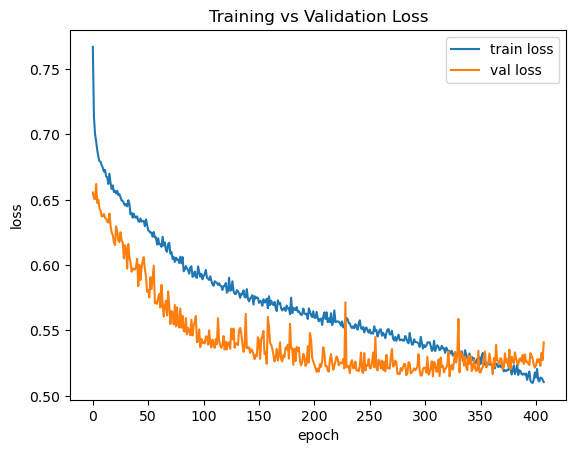

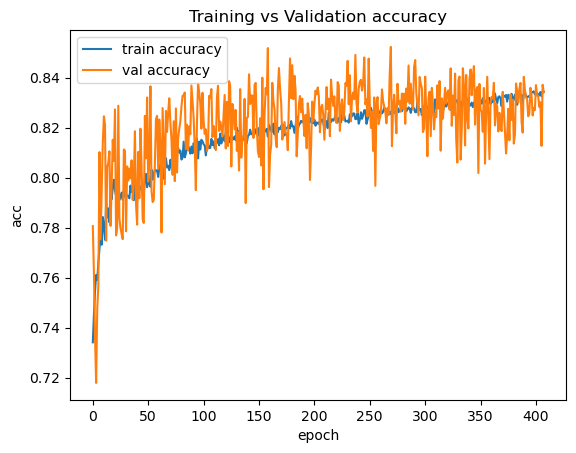

In [41]:
import json, os
import matplotlib.pyplot as plt

def _load_history_fallback():
    path = "artifacts/history.json"
    if os.path.exists(path):
        with open(path, "r") as f:
            return json.load(f)
    return None

# Use in-memory 'history' if present; else load from disk
try:
    _hist = history
except NameError:
    _hist = _load_history_fallback()

if _hist is None:
    print("No history found. Define a `history` dict or save it to artifacts/history.json.")
else:
    # Loss
    plt.figure()
    plt.plot(_hist.get("train_loss", []), label="train loss")
    plt.plot(_hist.get("val_loss", []), label="val loss")
    plt.xlabel("epoch"); plt.ylabel("loss"); plt.title("Training vs Validation Loss")
    plt.legend(); plt.show()

    # MAE
    plt.figure()
    plt.plot(_hist.get("train_acc", []), label="train accuracy")
    plt.plot(_hist.get("val_acc", []), label="val accuracy")
    plt.xlabel("epoch"); plt.ylabel("acc"); plt.title("Training vs Validation accuracy")
    plt.legend(); plt.show()


In [42]:

# Inference (probabilities and 0/1)
def predict_markers(model, graphs, device=cfg.device, thr=0.5):
    model.eval().to(device)
    preds, probs, trues = [], [], []
    for g in graphs:
        gg = g.to(device)
        with torch.no_grad():
            logits, _ = model(gg.x, gg.edge_index)
            p = torch.sigmoid(logits)
            yhat = (p >= thr).float()
        preds.append(yhat.cpu()); probs.append(p.cpu()); trues.append(gg.y.cpu())
    return torch.cat(trues,0).numpy(), torch.cat(probs,0).numpy(), torch.cat(preds,0).numpy()

Y_true_val, P_val, Y_hat_val = predict_markers(model, inv_val, device=cfg.device, thr=0.5)

# Quick per-marker accuracy/readout
for j, name in enumerate(sel_names):
    acc = (Y_hat_val[:, j] == Y_true_val[:, j]).mean()
    posr = Y_true_val[:, j].mean()
    print(f"{name:>16s}: acc={acc:.3f} | pos_rate={posr:.3f}")


            LGR5: acc=0.666 | pos_rate=0.140
           AldoB: acc=0.741 | pos_rate=0.417
       Serotonin: acc=0.995 | pos_rate=0.004
        Lysozyme: acc=0.916 | pos_rate=0.026


* **prec** = **precision** = TP / (TP + FP)
  “Of the cells I predicted **positive** for this marker, what fraction were actually positive?”

* **rec** = **recall** (a.k.a. sensitivity) = TP / (TP + FN)
  “Of the cells that were actually **positive**, what fraction did I catch?”

* **F1** = harmonic mean of precision & recall = 2 · (prec · rec) / (prec + rec)
  Balances the trade-off: you only get a high F1 if **both** precision and recall are high.

Where:

* **TP** = true positives, **FP** = false positives, **FN** = false negatives.
* Values are in [0,1].
* **Accuracy** can be misleading when positives are rare (predicting all zeros yields high accuracy, but recall=0 and thus F1≈0).

For multi-label:

* We compute these **per marker** (per column).
* You can also report **micro** averages (count TP/FP/FN over all markers then compute metrics) or **macro** averages (average the per-marker metrics), but the printout you saw is **per marker**.


In [43]:
import numpy as np
import torch

def per_marker_metrics(y_true, y_prob, threshold=0.5, names=None):
    """
    y_true: (N,K) in {0,1}
    y_prob: (N,K) in [0,1] (sigmoid outputs)
    """
    y_hat = (y_prob >= threshold).astype(np.float32)
    K = y_true.shape[1]
    lines = []
    for j in range(K):
        t = y_true[:, j].astype(np.float32)
        p = y_hat[:, j].astype(np.float32)
        pos = t.sum(); neg = (1.0 - t).sum()
        tp = float((p * t).sum())
        fp = float((p * (1.0 - t)).sum())
        fn = float(((1.0 - p) * t).sum())
        tn = float(((1.0 - p) * (1.0 - t)).sum())
        prec = tp / (tp + fp + 1e-12)
        rec  = tp / (tp + fn + 1e-12)
        f1   = 2 * prec * rec / (prec + rec + 1e-12)
        acc  = (tp + tn) / max(pos + neg, 1.0)
        name = names[j] if names else f"marker_{j}"
        lines.append((name, acc, prec, rec, f1, pos / max(pos+neg, 1.0)))
    return lines

# Usage after inference:
# Y_true_val: (N,K) ground truth; P_val: (N,K) probabilities (sigmoid)
stats = per_marker_metrics(Y_true_val, P_val, threshold=0.5, names=sel_names)
for name, acc, prec, rec, f1, pr in stats:
    print(f"{name:>16s} | Accuracy={acc:.3f}  Precision={prec:.3f}  Recall={rec:.3f}  F1={f1:.3f}  positivity-rate={pr:.3f}")


            LGR5 | Accuracy=0.666  Precision=0.277  Recall=0.864  F1=0.420  positivity-rate=0.140
           AldoB | Accuracy=0.741  Precision=0.680  Recall=0.716  F1=0.697  positivity-rate=0.417
       Serotonin | Accuracy=0.995  Precision=0.113  Recall=0.063  F1=0.081  positivity-rate=0.004
        Lysozyme | Accuracy=0.916  Precision=0.127  Recall=0.372  F1=0.189  positivity-rate=0.026
